# Задача : идентификации взломщика по его поведению в сети Интернет
https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2

# Импорт

In [1]:
import pandas as pd
import numpy as np
#!pip install category_encoders
import category_encoders as ce
import pickle
import re
#!pip install tldextract
#import tldextract
import os

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from lightgbm import LGBMClassifier
from sklearn.svm import LinearSVC
#from catboost import CatBoostClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Загрузка данных

In [2]:
#os.chdir('/kaggle/input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/')

In [3]:
# Загрузка информации о сессиях, приведение признаков к формату datetime, установка индекса
df_train = pd.read_csv('train_sessions.csv', parse_dates=['time'+str(i) for i in range(1,11)], index_col='session_id')
df_test = pd.read_csv('test_sessions.csv', parse_dates=['time'+str(i) for i in range(1,11)], index_col='session_id')

# Сортировка данных по дате
df_train.sort_values(by = 'time1', inplace = True)

In [4]:
# Загрузка словаря site:id_site и приведение его к формату id_site:site
with open('site_dic.pkl', 'rb') as file:
        site_id = pickle.load(file)   
        id_site = {v:k for k, v in site_id.items()}
        id_site[0] = 'unknown'
        del site_id

In [5]:
# Словарь id_site:site
for index, kv in enumerate(id_site.items()):
    print(kv)
    
    if index == 10:
        break

(25075, 'www.abmecatronique.com')
(13997, 'groups.live.com')
(42436, 'majeureliguefootball.wordpress.com')
(30911, 'cdt46.media.tourinsoft.eu')
(8104, 'www.hdwallpapers.eu')
(37491, 'img378.imageshack.us')
(5462, 'ecologie.nature.free.fr')
(35425, 'www.ibcn.intec.ugent.be')
(30151, 'kissanime.com')
(38268, 'www.carolineconduiteformation.com')
(43641, 'images.mystockphoto.com')


# Анализ данных

In [6]:
# Информация о сессиях
df_train.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,945.0,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,946.0,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,952.0,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


## Пропуски в данных

### Train

In [7]:
# Все пропуски можно объяснить природой датасета. Отсутствующие поля означают, что в данной сессии не было захода на сайт в timeN
# В будущем, на этапе обработки данных эти пропуски будут обработаны
pd.DataFrame({'Column': df_train.columns.to_list(),
              'NaN_percentage': np.array(df_train.isna().sum().to_list()) / len(df_train) * 100,
              'Number of unique elements' : df_train.nunique().to_list(),
              'Data type': pd.Series(df_train.columns.to_list()).apply(lambda row: df_train[row].dtype)
             })

,Column,NaN_percentage,Number of unique elements,Data type
0,site1,0.000000,15765,int64
1,time1,0.000000,236707,datetime64[ns]
2,site2,1.365746,15821,float64
3,time2,1.365746,233597,datetime64[ns]
4,site3,2.619488,15759,float64
5,time3,2.619488,230761,datetime64[ns]
6,site4,3.644094,15775,float64
7,time4,3.644094,228188,datetime64[ns]
8,site5,4.626895,15840,float64
9,time5,4.626895,225795,datetime64[ns]


### Test

In [8]:
# Все пропуски можно объяснить природой датасета. Отсутствующие поля означают, что в данной сессии не было захода на сайт в timeN
# В будущем, на этапе обработки данных эти пропуски будут обработаны
pd.DataFrame({'Column': df_test.columns.to_list(),
              'NaN_percentage': np.array(df_test.isna().sum().to_list()) / len(df_test) * 100,
              'Number of unique elements' : df_test.nunique().to_list(),
              'Data type': pd.Series(df_test.columns.to_list()).apply(lambda row: df_test[row].dtype)
             })

,Column,NaN_percentage,Number of unique elements,Data type
0,site1,0.000000,6326,int64
1,time1,0.000000,77269,datetime64[ns]
2,site2,1.798374,6207,float64
3,time2,1.798374,75845,datetime64[ns]
4,site3,3.287559,6138,float64
5,time3,3.287559,74786,datetime64[ns]
6,site4,4.366100,6208,float64
7,time4,4.366100,73967,datetime64[ns]
8,site5,5.381838,6177,float64
9,time5,5.381838,73130,datetime64[ns]


## Баланс классов

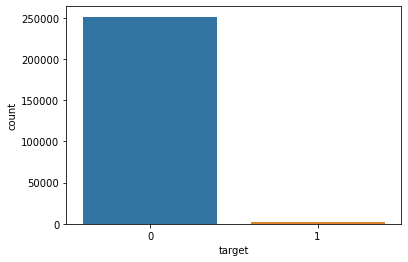

In [9]:
# Видим, что классы несбалансированны
sns.countplot(x = 'target', data = df_train);

# Обработка данных

In [10]:
def process_site_dictionary(id_site):
    
    for k in id_site:
        
        id_site[k] = id_site[k].replace('www.','')
        
        if 'cedexis-radar.net' in id_site[k]:
            id_site[k] = 'cedexis-radar.net'
        
#         domain = tldextract.extract(id_site[k]).domain
#         suffix = tldextract.extract(id_site[k]).suffix
        
#         id_site[k] = '{}.{}'.format(domain, suffix)
        
    return id_site
    

In [11]:
id_site = process_site_dictionary(id_site.copy())

In [13]:
class TextDataPreparator(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        sites = ['site' + str(i) for i in range(1, 11)]
               
        X = X[sites].fillna(0).astype('int').apply(lambda row:' '.join([id_site[i] for i in row]), axis=1).tolist()
        
        return X
    
vectorizer_params={'ngram_range': (1, 4), 
                   'max_features': 36000,
                   'tokenizer': lambda s: s.split(),
                   'min_df':3
                  }

vectorizer_pipeline = Pipeline([
    ('text_data_preparation', TextDataPreparator()),
    ('tfidf_vectorizer', TfidfVectorizer(**vectorizer_params))
])

### Пайплайн для выделения новых признаков из времени (one-hot)

In [14]:
# Преобразование hour, day_of_week, month, year через one-hot encoding показывает хорошие результаты
# по сравнению с их стандартным предста
class PrepareToOneHotExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        times = ['time' + str(i) for i in range(1, 11)]
        
        hour = X['time1'].apply(lambda ts: ts.hour)
                    
        day_of_week = (X['time1'].dt.dayofweek).astype(int)
                
        month = (X['time1'].dt.month).astype(int) 
        
        year = (X['time1'].dt.year).astype(int)
             
       
        X = np.stack((day_of_week, month, year), axis = 1)
        
        return X

In [15]:
time_one_hot_feature_extractort_pipeline = Pipeline([
    ('prepare_to_one_hot_extractor', PrepareToOneHotExtractor()),
    ('one_hot_encoder', OneHotEncoder())
])

### Пайплайн для выделения новых признаков из времени

In [107]:
def make_harmonic_features_cos(value, period=24):
    value *= 2 * np.pi / period 
    return np.cos(value)

def make_harmonic_features_sin(value, period=24):
    value *= 2 * np.pi / period 
    return np.sin(value)

In [108]:
class TimeFeatureExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        hour = X['time1'].apply(lambda ts: ts.hour) # Только для других признаков
        
        hour_cos = hour.apply(lambda hour: make_harmonic_features_cos(hour)).values
        hour_sin = hour.apply(lambda hour: make_harmonic_features_sin(hour)).values
        
        morning = hour.apply(lambda hour: int(hour >= 7 and hour <= 11 )) 
        midday = hour.apply(lambda hour: int(hour >= 12 and hour <= 18)) 
        evening = hour.apply(lambda hour: int(hour >= 19 and hour <= 23))
        night = hour.apply(lambda hour: int(hour >= 0 and hour <= 6))
        
        weekend = (X['time1'].dt.dayofweek >= 5).astype(int)
                   
        month = (X['time1'].dt.month).astype(int) # Только для других признаков
        winter = month.apply(lambda month: int(month in [12,1,2])) 
        spring = month.apply(lambda month: int(month in [3,4,5])) 
        summer = month.apply(lambda month: int(month in [6,7,8])) 
        fall = month.apply(lambda month: int(month in [9,10,11])) 
              
        
        X = np.stack((hour_cos, hour_sin, morning, midday, evening, night, weekend, winter, spring, summer, fall), axis = 1)
        
        return X

In [109]:
time_feature_extractor_pipeline = Pipeline([
    ('time_feature_extractor', TimeFeatureExtractor())
])

### Пайплайн для выделения новых признаков из сессии в целом

In [110]:
def get_time_diff(row): 
    time_length = row.shape[0] - 1 
    time_diff = [0] * time_length 
    i = 0 
    while (i < time_length):
        if pd.notnull(row[i+1]):
            time_diff[i] = (row[i+1] - row[i]) / np.timedelta64(1,'s') 
        else:
            time_diff[i] = 0
        i += 1 
    return time_diff

In [111]:
class SessionFeatureExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        sites = ['site' + str(i) for i in range(1, 11)]
        times = ['time' + str(i) for i in range(1, 11)]
        
        # Длительность сессии в миллисекундах (логарифмирована для нормализации)
        #session_duration_normalized = np.log((X[times].max(axis=1) - X[times].min(axis=1)).astype('timedelta64[ms]').replace(0,1))
        #session_duration_normalized = (X[times].max(axis=1) - X[times].min(axis=1)).astype('timedelta64[ms]').astype(int) ** 0.2
        session_duration_normalized = np.log(((X[times].max(axis=1) - X[times].min(axis=1)).astype('timedelta64[ms]') / 1000) + 1)
        
        time_between = X[times].apply(lambda row: get_time_diff(row), axis = 1)
        time_between = np.array([item for item in time_between])
        
        
        seconds = (X[times].max(axis=1) - X[times].min(axis=1)) / np.timedelta64(1, 's')
        minutes = ((X[times].max(axis=1) - X[times].min(axis=1)) / np.timedelta64(1, 'm')).round(2)
        
        # Количество уникальных сайтов
        unqique_sites = X[sites].apply(lambda row: len(set(filter(lambda site: pd.isna(site) == False, row))), axis = 1)
        
        # Количество пустых ячеек с сайтами
        null_sites_count = X[sites].isnull().sum(axis = 1)
        
        # Количество посещенных сайтов за сессию
        sites_count = 10 - null_sites_count
        
        # Время на один сайт
        time_per_site = (seconds / sites_count)
        
        X = np.stack((
                    #seconds,
                    session_duration_normalized
                    ,unqique_sites
                    ,null_sites_count
                    ,sites_count
                    ,time_per_site
        ), axis = 1)
        
        #X = np.c_[time_between, A]
        
        return X

In [112]:
session_feature_extractor_pipeline = Pipeline([
    ('session_feature_extractor', SessionFeatureExtractor())
])

# Создание модели

In [113]:
# Объединение признаков полученных их различных пайплайнов в один датасет
full_pipeline = FeatureUnion(transformer_list=[
('vectorizer_pipeline', vectorizer_pipeline),
('time_one_hot_feature_extractort_pipeline', time_one_hot_feature_extractort_pipeline),
('time_feature_extractor_pipeline', time_feature_extractor_pipeline),
('session_feature_extractor_pipeline', session_feature_extractor_pipeline)
])

In [136]:
%%time
# Получение датасетов для обучения и предсказания
X_train = full_pipeline.fit_transform(df_train) # Обработанный обучающий датасет (Готовые признаки)
X_test = full_pipeline.transform(df_test) # Обработанный тестовый датасет

y_train = df_train["target"].astype('int').values # Таргет

Wall time: 7min 15s


In [137]:
# Создание валидационной выборки
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [138]:
# Фолды для валидации
time_split = TimeSeriesSplit(n_splits=10)

In [139]:
logit = LogisticRegression(random_state=42)
dtr = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
#lgbm = LGBMClassifier(random_state=42)

In [140]:
%%time
# Результаты моделей на кросс-валидации
for estimator in [logit]:
    cv_scores = cross_val_score(estimator, X_train, y_train, cv=time_split, 
                        scoring='roc_auc', n_jobs=3)
    
    model_type = str(type(estimator)).split('.')[-1].replace("'>",'') # Выделение названия модели из type(model)

    cv_scores.mean()
    print('Model: {}. cv_score_mean: {}'.format(model_type,cv_scores.mean()))

Model: LogisticRegression. cv_score_mean: 0.9589103748511498
Wall time: 23.8 s


## Обучение

#### Logistic Regression

In [141]:
logit_grid_searcher = GridSearchCV(estimator=logit 
                                        ,param_grid={
                                                     'C': list(np.linspace(0, 10, 12))
                                                    #'C': [4.777777777777778]
                                                    ,'solver': ['liblinear']
                                                    ,'dual':[False]
                                                    ,'max_iter':[100]
                                                    ,'tol': [0.0001]
                                                             }
                                        ,scoring='roc_auc'
                                        ,n_jobs=7
                                        ,cv=time_split 
                                        ,verbose=1)

logit_grid_searcher.fit(X_train, y_train)

print('AUC: ', logit_grid_searcher.best_score_)
print('Best params: ', logit_grid_searcher.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   54.3s
[Parallel(n_jobs=7)]: Done 120 out of 120 | elapsed:  5.5min finished


AUC:  0.9833326168690446
Best params:  {'C': 10.0, 'dual': False, 'max_iter': 100, 'solver': 'liblinear', 'tol': 0.0001}


### Валидация

In [142]:
from sklearn.metrics import roc_auc_score, make_scorer

In [143]:
val_predictions = logit_grid_searcher.predict_proba(X_val)[:, 1]

In [144]:
score = roc_auc_score_auc_score(y_val, val_predictions)
print('Validation ROC-AUC: ', score)

Validation ROC-AUC:  0.9829402484000872


In [ ]:
validation_score = [0.9829402484000872]

#### LightGBM

In [121]:
# lgbm_grid_searcher = RandomizedSearchCV(estimator=lgbm 
#                                         ,param_distributions={
#                                                     'n_estimators': [100, 200, 500]
#                                                     ,'max_depth': range(0,7)
#                                                     ,'learning_rate' : [0.1,0.05,0.2]
#                                                     ,'reg_alpha': list(np.linspace(0, 7, 20))
#                                                     ,'reg_lambda': list(np.linspace(0, 7, 20))}
#                                         ,scoring='roc_auc'
#                                         ,n_jobs=2
#                                         ,cv=time_split 
#                                         ,verbose=1)

# lgbm_grid_searcher.fit(X_train, y_train)

# print('AUC: ', lgbm_grid_searcher.best_score_)

#### Decision Tree

In [122]:
# dtr_randomized_searcher = RandomizedSearchCV(estimator = dtr
#                                             ,param_distributions={'min_samples_split': np.arange(2,4),
#                                                                   'min_samples_leaf': np.arange(1,4),
#                                                                    'criterion': ['gini', 'entropy']}
#                                             ,scoring='roc_auc'
#                                             ,n_jobs=2
#                                             ,cv = time_split
#                                             ,verbose=1)

# dtr_randomized_searcher.fit(X_train, y_train)

# print('AUC: ', dtr_randomized_searcher.best_score_)

#### Random Forest

In [123]:
# rf_randomized_searcher = RandomizedSearchCV(estimator = rf
#                                             ,param_distributions={'min_samples_split': np.arange(2,4),
#                                                                   'min_samples_leaf': np.arange(1,4),
#                                                                    'criterion': ['gini', 'entropy']}
#                                             ,scoring='roc_auc'
#                                             ,n_jobs=2
#                                             ,cv = time_split
#                                             ,verbose=1)

# rf_randomized_searcher.fit(X_train, y_train)

# print('AUC: ', rf_randomized_searcher.best_score_)

#### Catboost

In [125]:
# catboost_cl = CatBoostClassifier(
#     random_seed = 42,
#     loss_function = 'Logloss',
#     eval_metric='AUC',
#     reg_lambda = 3.888888888888889
# )

In [126]:
# catboost_cl_grid_search = catboost_cl.grid_search(param_grid={'reg_lambda':  list(np.linspace(3, 7, 10))},
#                         X = X_train,
#                         y = y_train)

In [127]:
#catboost_cl.fit(X_train, y_train, plot=True)

# Стэкинг результатов

In [128]:
logit_test_pred = logit_grid_searcher.predict_proba(X_test)[:, 1]
#catboost_test_pred = catboost_cl.predict_proba(X_test)[:,1]
#lgbm_test_pred = lgbm_grid_searcher.predict_proba(X_test)[:, 1]
#rf_test_pred = rf_randomized_searcher.predict_proba(X_test)[:, 1]

In [129]:
final_test_pred = logit_test_pred

# Сохранение результатов предсказания лучшей модели

In [130]:
# Метод для сохранения файла с результатами предсказания для тестового набора
def write_to_submission_file(predicted_labels, out_file, target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels, index = np.arange(1, predicted_labels.shape[0] + 1), columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [131]:
write_to_submission_file(final_test_pred, 'submission_2020_08.csv')

In [132]:
!kaggle competitions submit catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2 -f submission_2020_08.csv -m "2020_08"

401 - Unauthorized
